# Query Fee Claim Frequency and Magnitude Study

Library Imports

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft,fftfreq

import model.parts.utils as utils

%matplotlib inline

In [2]:
def load_all_events_to_pandas_df(path, agent_event_path = None):
    # make them ordered by blockNumber and logindex
    # squish them because time between doesn't matter
    # **but they have to be interleaved between all event types.
    # reset index
    # break back out to distinct types
    # use block number, resolve conflicts with log index.
    all_events = pd.read_csv(f'{path}')

    if agent_event_path:
        all_events = pd.concat([all_events, pd.read_csv(agent_event_path)])

    all_events.reset_index(inplace=True)
    all_events.sort_values(['blockNumber', 'logIndex'], ascending=[True, True])
    all_events = all_events.rename(columns={'index': 'timestep'})
    
    # start with timestep 1.
    all_events['timestep'] = all_events['timestep'] + 1
    all_events.set_index('timestep', inplace=True, drop=False)
    return all_events

In [3]:
event_path = 'another_indexer/single_indexer/singleIndexer.csv'

In [4]:
all_events_df = load_all_events_to_pandas_df(event_path)

In [5]:
all_events_df.head()

,timestep,allocationID,blockNumber,epoch,id,indexer,logIndex,subgraphDeploymentID,tokens,type,...,shares,eventTime,until,indexingRewardCut,queryFeeCut,delegationFees,amount,signer,signal,subgraphDeployment
timestep,,,,,,,,,,,,,,,,,,,,,
1,1,NaN,11474009,NaN,0xcb621a8a549e4e3c616a7a1e27dc92b28722c90ac37f...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,121.0,NaN,NaN,delegationParametersUpdateds,...,NaN,NaN,NaN,1000000.0,1000000.0,NaN,NaN,NaN,NaN,NaN
2,2,NaN,11474009,NaN,0xcb621a8a549e4e3c616a7a1e27dc92b28722c90ac37f...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,122.0,NaN,9615385000000000000000000,stakeDepositeds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,11474307,NaN,0x938641c2dbfd4562c7ab8c60ca98f11394d161ead6b9...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,17.0,NaN,165851137200000000000000,stakeDelegateds,...,165851137200000000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,11474332,NaN,0x67278b0af539dff48945b3a430ada90de00526aed433...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,38.0,NaN,251819644650000000000000,stakeDelegateds,...,251819644650000000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,NaN,11474426,NaN,0x19cf8bd30df43cc8518c16bfce7297c32495bbc3c4c1...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,162.0,NaN,NaN,delegationParametersUpdateds,...,NaN,NaN,NaN,90000.0,80000.0,NaN,NaN,NaN,NaN,NaN


In [6]:
len(all_events_df)

12150

In [7]:
all_events_df.columns

Index(['timestep', 'allocationID', 'blockNumber', 'epoch', 'id', 'indexer',
       'logIndex', 'subgraphDeploymentID', 'tokens', 'type', 'isDelegator',
       'sender', 'curationFees', 'from', 'rebateFees', 'delegator', 'shares',
       'eventTime', 'until', 'indexingRewardCut', 'queryFeeCut',
       'delegationFees', 'amount', 'signer', 'signal', 'subgraphDeployment'],
      dtype='object')

In [8]:
all_events_df.type.unique()

array(['delegationParametersUpdateds', 'stakeDepositeds',
       'stakeDelegateds', 'stakeDelegatedLockeds', 'allocationCreateds',
       'rewardsAssigneds', 'allocationCloseds', 'rebateClaimeds',
       'allocationCollecteds', 'stakeDelegatedWithdrawns', 'MintSignal',
       'BurnSignal'], dtype=object)

In [9]:
all_events_df['curationFees'] = all_events_df['curationFees'].astype(float)
all_events_df['curationFees'] = all_events_df['curationFees']/10e18

### Query Fee Magnitude

In [10]:
all_events_df.curationFees.describe()

count    16.000000
mean      0.452187
std       0.661510
min       0.011888
25%       0.180934
50%       0.180934
75%       0.201870
max       2.123845
Name: curationFees, dtype: float64

### Query Fee Frequency
#### Allocation Length

In [22]:
all_events_df[all_events_df['type']=='allocationCreateds']

,timestep,allocationID,blockNumber,epoch,id,indexer,logIndex,subgraphDeploymentID,tokens,type,...,shares,eventTime,until,indexingRewardCut,queryFeeCut,delegationFees,amount,signer,signal,subgraphDeployment
timestep,,,,,,,,,,,,,,,,,,,,,
36,36,0xb9ea968ea1cdf85bf2390e7703270e1f75168058,11477232,4.0,0xfb3a6dd7449f3a89bc020896cdf6f1281cf98387486f...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,253.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,4807692000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,38,0xaceef199756a63f97b0f31bfebb7065b17796971,11477243,4.0,0x24da63bdf5f0ab8e715a29cb670ed4521a14427e41c4...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,118.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,4807692000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,76,0x3303011d4f7d210e94ccb75530b773be55295b26,11480784,5.0,0x2c6abea652a0c1678bc00b49ff9bb665df6c3d6c6cd0...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,215.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,3920061000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,89,0x344ca9d6259079af198866f57f964f02d9b24b7e,11481994,5.0,0x8528c4b3a2db3801e4866661306b5370f9f03045ddcf...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,194.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,3920061000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,90,0xdd05d8475fe6dd25818f120a462b91117fb496ec,11482008,5.0,0xaa655dc2c8f8ecaa29cdc7d43609d030abbf8abcdfdf...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,254.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,3920061000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,92,0xa14edb298bdba89ba82ab8b24400f5eed78ea073,11482082,5.0,0x8a2ce9d4f8a23783b34204e52a07eaa1e8e18d888873...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,257.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,3920061000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,178,0x39376a04c6dd34c0e8f819b04de61e12fa8516ad,11486718,6.0,0x2c77255bdc2fa41d0e7a4c5d1291bff45f8c262c8416...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,201.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,9712986000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,179,0x952c46bdd67f724dcd16e3c0305b68cb23cb9d30,11486719,6.0,0x99963e4808e28061f9c771543950da970e6ef590ddb0...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,221.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,9712986000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301,301,0x7db76dcf1dd154625260b2e8497350700035b660,11495370,7.0,0x5154ba118d0ad706f723e31c098f3e562e0ca12042c3...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,231.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,21032766000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
all_events_df[all_events_df['type']=='allocationCollecteds']

,timestep,allocationID,blockNumber,epoch,id,indexer,logIndex,subgraphDeploymentID,tokens,type,...,shares,eventTime,until,indexingRewardCut,queryFeeCut,delegationFees,amount,signer,signal,subgraphDeployment
timestep,,,,,,,,,,,,,,,,,,,,,
466,466,0xbb18ad1ed013984dc0d7b3e2090ec3e762f9d096,11535348,13.0,0x63e7d5ee35e4229e6ed98db608db7b7a64d305183cd0...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,163.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,137509689357001388186,allocationCollecteds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
704,704,0x7368b5f5d52542faca67eb24e8a27ebbe06b3005,11683972,35.0,0x66eb95e8f39ee93a63bd69544f05d8509341794fec26...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,306.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,26735411802895408127,allocationCollecteds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
705,705,0x7368b5f5d52542faca67eb24e8a27ebbe06b3005,11684927,35.0,0x76e8c5dbebe8fa3443be6f0f3b97254451e0a25a8843...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,269.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,177886072492066675018,allocationCollecteds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
779,779,0xa02a4bdc703b7d17aefcfff033a8b51561b8e6e6,11724106,41.0,0x47c983748588a85fb29481b3da895907ad5c52422bc6...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,176.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,214529777397159839053,allocationCollecteds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
819,819,0x82bf16f0038c28495d235186a2c8941736bb3ed8,11758871,46.0,0xb1e7fcf5965db0211fbaa142200c10d11dd4c695e107...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,226.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,18276136055873106202,allocationCollecteds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
820,820,0x82bf16f0038c28495d235186a2c8941736bb3ed8,11758940,46.0,0x83edb45978ad681e2b3cc860217a194c07eafe670cbe...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,209.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,18276136055873106202,allocationCollecteds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
821,821,0x82bf16f0038c28495d235186a2c8941736bb3ed8,11758940,46.0,0x439346fa952aae7fb9b37afa50a18d1afdcbcc4c547e...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,215.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,18276136055873106202,allocationCollecteds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
822,822,0x82bf16f0038c28495d235186a2c8941736bb3ed8,11758940,46.0,0xd38946366f9151a06fe9de117fd58106f5c9134369c3...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,221.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,18276136055873106202,allocationCollecteds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
823,823,0x82bf16f0038c28495d235186a2c8941736bb3ed8,11758940,46.0,0x9a7ae0afc94bc313ba4c2335af3bca0765d73c1c863d...,0x7ab4cf25330ed7277ac7ab59380b68eea68abb0e,227.0,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,18276136055873106202,allocationCollecteds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
collected_ids = all_events_df[all_events_df['type']=='allocationCollecteds']['allocationID']

In [24]:
created_df = all_events_df[all_events_df['type']=='allocationCreateds']

In [31]:
epoch_list =[] 
for id in collected_ids:
    matched_record = created_df[created_df['allocationID']==id]
    epoch_list.append(matched_record.epoch.values)

In [32]:
epoch_list

[array([10.]),
 array([20.]),
 array([20.]),
 array([31.]),
 array([41.]),
 array([41.]),
 array([41.]),
 array([41.]),
 array([41.]),
 array([41.]),
 array([41.]),
 array([41.]),
 array([41.]),
 array([67.]),
 array([67.]),
 array([67.])]

In [33]:
len(epoch_list)

16

In [40]:
epoch_df = pd.DataFrame(epoch_list,columns=['epoch'])

In [41]:
epoch_df

,epoch
0,10.0
1,20.0
2,20.0
3,31.0
4,41.0
5,41.0
6,41.0
7,41.0
8,41.0
9,41.0


In [47]:
epoch_df['time_delta'] =all_events_df[all_events_df['type']=='allocationCollecteds'].epoch.values - epoch_df.epoch.values

In [48]:
epoch_df

,epoch,time_delta
0,10.0,3.0
1,20.0,15.0
2,20.0,15.0
3,31.0,10.0
4,41.0,5.0
5,41.0,5.0
6,41.0,5.0
7,41.0,5.0
8,41.0,5.0
9,41.0,5.0


In [68]:
epoch_df.time_delta.describe()

count    16.000000
mean      8.062500
std       4.639953
min       3.000000
25%       5.000000
50%       5.000000
75%      11.500000
max      17.000000
Name: time_delta, dtype: float64

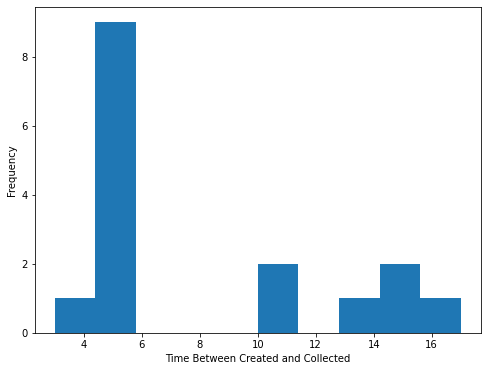

In [56]:
plt.figure(figsize=(8,6))
plt.hist(epoch_df.time_delta)
plt.xlabel('Time Between Created and Collected')
plt.ylabel('Frequency')
plt.show()

In [61]:
epoch_freq = fft(np.array(epoch_df.time_delta))

In [62]:
epoch_freq

array([129.        -0.j        ,  35.26278953+0.27503283j,
         5.77817459+0.12132034j, -16.47156141+0.05086207j,
       -20.        +1.j        , -12.98428272+2.8792892j ,
        -9.77817459+4.12132034j, -13.80694541+3.10345996j,
       -17.        -0.j        , -13.80694541-3.10345996j,
        -9.77817459-4.12132034j, -12.98428272-2.8792892j ,
       -20.        -1.j        , -16.47156141-0.05086207j,
         5.77817459-0.12132034j,  35.26278953-0.27503283j])

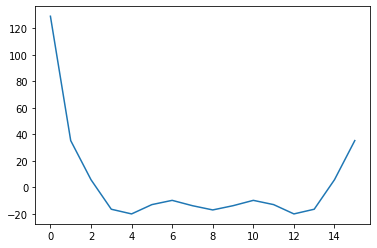

In [67]:
plt.plot(epoch_freq.real)
plt.show()

In [16]:
allocation_created = all_events_df[all_events_df['type']=='allocationCreateds']

In [17]:
set(allocation_created['allocationID']).intersection(set(collected_query['allocationID']))

{'0x7368b5f5d52542faca67eb24e8a27ebbe06b3005',
 '0x82bf16f0038c28495d235186a2c8941736bb3ed8',
 '0xa02a4bdc703b7d17aefcfff033a8b51561b8e6e6',
 '0xbb18ad1ed013984dc0d7b3e2090ec3e762f9d096',
 '0xd310dce490026527d6b6356d1cdc52d4d164ddfa'}

In [19]:
event_type = all_events_df.groupby('type')

In [ ]:
allocation_created_match = allocation_created[allocation_created['allocationID']==collected_query['allocationID']]

In [ ]:
set(all_events_df['allocationID']).intersection(set(collected_query['allocationID']))

In [ ]:
allocation_created.where(all_events_df.allocationID.values==collected_query.allocationID.values).notna()

In [ ]:
alloc_start = all_events_df[all_events_df['type']=='allocationCreateds']
for i in collected_query:
    alloc_start = alloc_start[alloc_start['allocationID']==i]
    print(alloc_start)
# alloc_start = al
# for i in collected_query:
#     alloc_start = alloc_start.join() all_events_df[all_events_df['type']=='allocationCreateds'] and all_events_df['allocationID']==i]

In [ ]:
alloc_start